# A data-driven greedy algorithm
...first the usual set-up

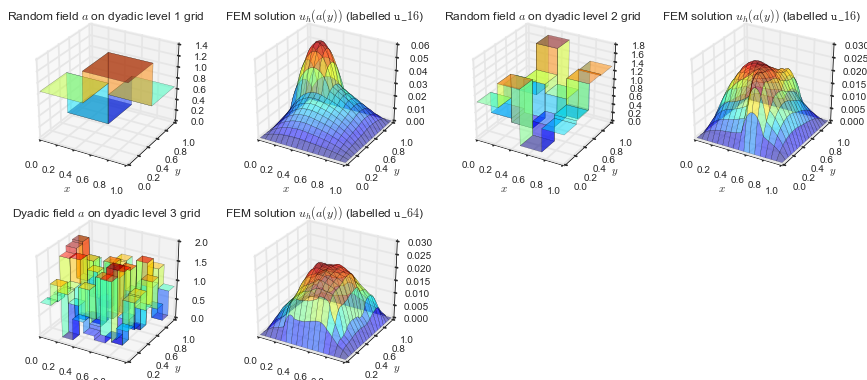

In [1]:
import numpy as np
import importlib
import dyadic_fem as df
import point_generator as pg
import seaborn as sns
import matplotlib.pyplot as plt
import pdb
importlib.reload(df)
importlib.reload(pg)
%matplotlib inline

fem_div = 7

a_bar = 1.0
c = 0.9

a_4 = df.make_dyadic_random_field(div=1, a_bar=a_bar, c=c, seed=1)
fem_4 = df.DyadicFEMSolver(div=fem_div, rand_field=a_4, f=1.0)
fem_4.solve()

a_16 = df.make_dyadic_random_field(div=2, a_bar=a_bar, c=c, seed=1)
fem_16 = df.DyadicFEMSolver(div=fem_div, rand_field=a_16, f=1.0)
fem_16.solve()

a_64 = df.make_dyadic_random_field(div=3, a_bar=a_bar, c=c, seed=1)
fem_64 = df.DyadicFEMSolver(div=fem_div, rand_field=a_64, f=1.0)
fem_64.solve()

fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(3, 4, 1, projection='3d')
a_4.plot(ax, title='Random field $a$ on dyadic level 1 grid')
ax = fig.add_subplot(3, 4, 2, projection='3d')
fem_4.u.plot(ax, title='FEM solution $u_h(a(y))$ (labelled $\mathtt{u\_16}$)')
ax = fig.add_subplot(3, 4, 3, projection='3d')
a_16.plot(ax, title='Random field $a$ on dyadic level 2 grid')
ax = fig.add_subplot(3, 4, 4, projection='3d')
fem_16.u.plot(ax, title='FEM solution $u_h(a(y))$ (labelled $\mathtt{u\_16}$)')
ax = fig.add_subplot(3, 4, 5, projection='3d')
a_64.plot(ax, title='Dyadic field $a$ on dyadic level 3 grid')
ax = fig.add_subplot(3, 4, 6, projection='3d')
fem_64.u.plot(ax, title='FEM solution $u_h(a(y))$ (labelled $\mathtt{u\_64}$)')
plt.show()

# Data-driven greedy algorithm
This algorithm makes a very simple adjustment to the greedy algorithm - it does the argmax search in the $W_m$ projection. Hopefully this will result in some control of the $\beta(V_n, W_m)$ measure, as we are always maximising _within_ $W_m$. Of course as $n \to m$ there is nothing we can do about $\beta(V_n, W_m) \to 0$, but hopefully it will help stave off this trend with enough time for the projection of $u$ on to $V_n$ to become small enough that our reconstruction efforts are improved.

One other advantage, provided that $W_m$ is orthonormal, is that we get to do everything in $\mathbb{R}^m$ rather than a basis of $H_0^1$. This makes things considerably faster than the greedy algorithm in $H_0^1$ by itself...

So what exactly do we do? We have a dictionary $\mathcal{D}$ of solutions $u$, which we get from generating MC or QMC points $y\in\mathbb{R}^{d}$, where $d=16$ in this case, find the field $a(y)$ and then solve for $u_h(a(y))$. The first element $v_1$ is chosen as 
$$ v_1 = {\arg\max}_{u\in \mathcal{D}} \| P_{W_m} u \| $$
and given our collection $V_{n-1}$ our next choice is
$$ v_n = {\arg\max}_{u\in \mathcal{D}} \| P_{W_m} (u - P_{V_{n-1}} u) \| $$

Let us assume that $W_m$ is orthonormal. Then we see that this computation can become
$$ v_n = {\arg\max}_{u\in \mathcal{D}} \left\| \sum_{i=1}^m \left( \langle w_i, u\rangle - \langle w_i, P_{V_{n-1}} u \rangle \right) \right\| $$

The trick is to see that we can express $P_{V_{n-1}} u$ in terms of $\langle w_i, v_j\rangle$, where $v_j\in V_{n-1}$. So - what we do when we start is compute all $\langle w_i, u\rangle$ for all $u\in\mathcal{D}$ at the start when we make our dictionary, and then we know all $\langle w_i, v_j\rangle$ as well, as the $v_j$ are drawn from $\mathcal{D}$.

So, with this knowledge, the whole operation can take place in $\mathbb{R}^m$, which makes things much much faster. For any $v\in\mathcal{D}$ we write $v^{W_m} \in \mathbb{R}^{m}$ for the vector with elements $\langle w_i, v\rangle$. Now, we have that
$$ \begin{align} v_n &= {\arg\max}_{u\in \mathcal{D}} \| P_{W_m} (u - P_{V_{n-1}} u) \|  \\ 
&= {\arg\max}_{u\in \mathcal{D}} \| P_{W_m} u \|^2 - \| P_{W_m} P_{V_{n-1}} u \|^2 \\
&= {\arg\max}_{u\in \mathcal{D}}  \sum_{i=1}^m \langle w_i, u\rangle^2 - \left\| \sum_{i=1}^m \langle w_i, P_{V_{n-1}}  u\rangle \right\| , \end{align}$$
where finding $P_{V_{n-1}} u = (c_i v_i)_{i=1}^{n-1}$ where the $c_i$ are a simple solution of the linear equation
$$
\sum_{j=1}^{n-1} v_i^{W_m} \cdot v_j^{W_m} c_j = v_i^{W_m}\cdot u
$$
Now we are looking at simple $\mathbb{R}^m$ inner products, rather than computationally expensive $H_0^1$ inner products... so now the computation becomes 
$$v_n = {\arg\max}_{u\in \mathcal{D}}  \sum_{i=1}^m \langle w_i, u\rangle^2 - \sum_{i=1}^m \sum_{j=1}^{n-1} c_j^2 \langle w_i, v_j\rangle^2 $$
and we have all of the $\langle w_i, u\rangle$ and $\langle w_i, v_j\rangle$ saved in memory, so we just have to find the $c_j$ at each step.

[]

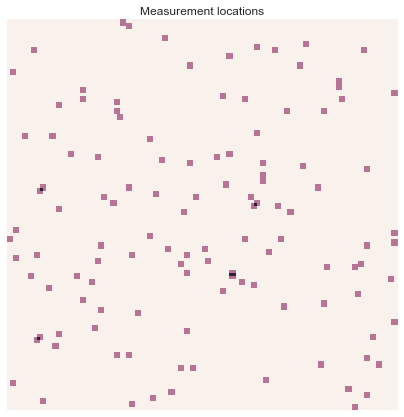

In [19]:
# local_width is the width of the measurement squares
local_width = 2

m = 120

# We make the ambient spaces for Wm and Vn
np.random.seed(2)

Wm, Wloc = df.make_random_local_integration_basis(m=m, div=fem_div, width=local_width, space='H1', return_map=True)
Wm = Wm.orthonormalise()

fig, ax = plt.subplots(figsize=(7,7))     
sns.heatmap(Wloc.values, xticklabels=False, yticklabels=False, cbar=False, ax=ax)
ax.set_title('Measurement locations')
plt.savefig('ddgrb_measurements.pdf')
plt.plot()

In [ ]:
basis_div = 2

pd = pg.MonteCarlo(d=16, n=5000, lims=[-1, 1], seed=1)
div_levels = range(2,4)
ns = np.zeros(len(div_levels))

hat_err = []
hat_ns = []

red_err = []
grb_err = []
gbd_err = []
sin_err = []

#n = m # just an adjustment for now, put a singular matrix catcher in the procedure!!!

Vn_greedy_data = df.data_based_greedy_reduced_basis_construction(n=m, field_div=basis_div, fem_div=fem_div, \
                                                    point_dictionary = pd, Wm = Wm, a_bar=a_bar, c=c, verbose=True)

Vn_greedy = df.greedy_reduced_basis_construction(n=m, field_div=basis_div, fem_div=fem_div, \
                                                    point_dictionary = pd, a_bar=a_bar, c=c, verbose=True)

Vn_sin = df.make_sin_basis(fem_div, N=2**(fem_div-2), space='H1')

Vn_red, Vn_red_fields = df.make_reduced_basis(n=m, field_div=basis_div, fem_div=fem_div, space='H1', a_bar=a_bar, c=c)

ns = range(2,m+1,2)

for i in ns:
    Vn_sin_i = Vn_sin.subspace(slice(0,i))
    Vn_red_i = Vn_red.subspace(slice(0,i))
    Vn_greedy_i = Vn_greedy.subspace(slice(0,i))
    Vn_greedy_data_i = Vn_greedy_data.subspace(slice(0,i))
    
    sin_err.append((Vn_sin_i.project(fem_16.u) - fem_16.u).norm(space='H1'))
    red_err.append((Vn_red_i.project(fem_16.u) - fem_16.u).norm(space='H1'))
    grb_err.append((Vn_greedy_i.project(fem_16.u) - fem_16.u).norm(space='H1'))    
    gbd_err.append((Vn_greedy_data_i.project(fem_16.u) - fem_16.u).norm(space='H1'))    

for i, coarse_div in enumerate(div_levels):
    Vn_hat_i = df.make_hat_basis(div=coarse_div, space='H1')
    hat_err.append((Vn_hat_i.project(fem_16.u) - fem_16.u).norm(space='H1'))
    hat_ns.append(Vn_hat_i.n)

# Lets try a really big computation... with the data-driven greedy algo (which is much faster)

In [ ]:
gbd_big_err = []

pd = pg.MonteCarlo(d=16, n=100000, lims=[-1, 1], seed=1)
Vn_greedy_data_big = df.data_based_greedy_reduced_basis_construction(n=m, field_div=basis_div, fem_div=fem_div, \
                                                    point_dictionary = pd, Wm = Wm, a_bar=a_bar, c=c, verbose=True)

for i in ns:
    Vn_greedy_data_i = Vn_greedy_data_big.subspace(slice(0,i))    
    gbd_big_err.append((Vn_greedy_data_i.project(fem_16.u) - fem_16.u).norm(space='H1'))    


### Um... just for kicks we try a small dictionary

In [24]:
gbd_sm_err = []

pd = pg.MonteCarlo(d=16, n=2*m, lims=[-1, 1], seed=1)
Vn_greedy_data_sm = df.data_based_greedy_reduced_basis_construction(n=m, field_div=basis_div, fem_div=fem_div, \
                                                    point_dictionary = pd, Wm = Wm, a_bar=a_bar, c=c, verbose=False)

for i in ns:
    Vn_greedy_data_i = Vn_greedy_data_sm.subspace(slice(0,i))    
    gbd_sm_err.append((Vn_greedy_data_i.project(fem_16.u) - fem_16.u).norm(space='H1'))    

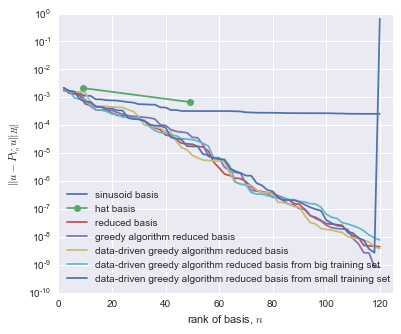

In [25]:
f, ax = plt.subplots(figsize=(6, 5))

ax.set(yscale="log")
plt.plot(ns, sin_err, label='sinusoid basis')
plt.plot(hat_ns, hat_err, label='hat basis', marker='o')
plt.plot(ns, red_err, label='reduced basis')
plt.plot(ns, grb_err, label='greedy algorithm reduced basis') 
plt.plot(ns, gbd_err, label='data-driven greedy algorithm reduced basis') 
plt.plot(ns, gbd_big_err, label='data-driven greedy algorithm reduced basis from big training set') 
plt.plot(ns, gbd_sm_err, label='data-driven greedy algorithm reduced basis from small training set') 
ax.set(xlabel='rank of basis, $n$', ylabel='$\|u - P_{V_n} u\|_{H_0^1}$')
ax.set_xlim([0, 125])
plt.legend(loc=3)
plt.savefig('ddgrb_projections.pdf')
plt.show()

In [ ]:
w = Wm.dot(fem_16.u)
u_p_w = Wm.project(fem_16.u)

ns = range(2, m+1, 2)

bases = [Vn_sin, Vn_red, Vn_greedy, Vn_greedy_data, Vn_greedy_data_big, Vn_greedy_data_sm]
basis_labels = ['Sinusoid basis', 'Reduced basis', 'Greedy algo basis', \
                'Data-driven greedy algo basis', 'Data-driven greedy algo from big dictionary', \
                'Data-driven greedy algo from small dictionary']

stats = np.zeros([5, len(bases), len(ns)])

for i, n in enumerate(ns):

    for j, Vn_big in enumerate(bases):
    
        Vn = Vn_big.subspace(slice(0,n))

        u_p_v = Vn.project(fem_16.u)
        BP = df.BasisPair(Wm, Vn)
        FB = BP.make_favorable_basis()
        u_star, v_star, w_p, v_w_p = FB.measure_and_reconstruct(fem_16.u)

        stats[0, j, i] = (fem_16.u-u_star).norm(space='H1')
        stats[1, j, i] = (u_star - v_star).norm(space='H1')
        stats[2, j, i] = FB.beta()
        stats[3, j, i] = np.linalg.cond(BP.G.T @ BP.G)
        stats[4, j, i] = (fem_16.u - u_p_v).norm(space='H1')

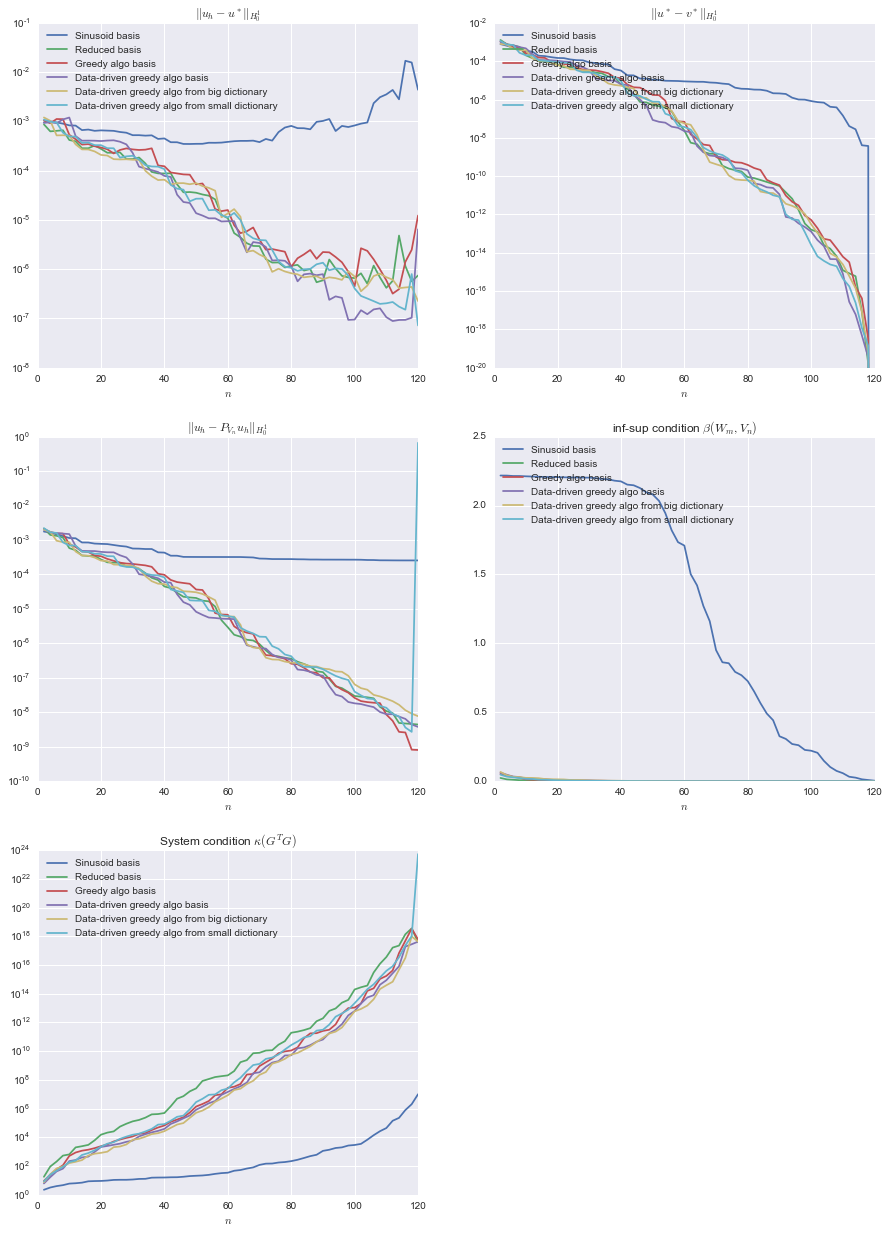

In [34]:
axs = []
fig = plt.figure(figsize=(15, 21))
axs.append(fig.add_subplot(3, 2, 1, title='$\| u_h - u^* \|_{H_0^1}$'))
axs[-1].set(yscale="log", xlabel='$n$')
axs.append(fig.add_subplot(3, 2, 2, title='$\| u^* - v^* \|_{H_0^1}$'))
axs[-1].set(yscale="log", xlabel='$n$')
axs.append(fig.add_subplot(3, 2, 3, title='$\| u_h - P_{V_n} u_h \|_{H_0^1}$'))
axs[-1].set(yscale="log", xlabel='$n$')
axs.append(fig.add_subplot(3, 2, 4, title=r'inf-sup condition $\beta(W_m, V_n)$'))
axs[-1].set(xlabel='$n$')
axs.append(fig.add_subplot(3, 2, 5, title=r'System condition $\kappa(G^T G)$'))
axs[-1].set(yscale="log", xlabel='$n$')

for j, basis_label in enumerate(basis_labels):

    axs[0].plot(ns, stats[0, j, :], label=basis_label)
    axs[0].legend(loc=2)
    axs[1].plot(ns, stats[1, j, :], label=basis_label)
    axs[1].legend(loc=2)
    axs[2].plot(ns, stats[4, j, :], label=basis_label)

    axs[3].plot(ns, stats[2, j, :], label=basis_label)
    axs[3].legend(loc=2)
    axs[4].plot(ns, stats[3, j, :], label=basis_label)
    axs[4].legend(loc=2)

    
plt.show()

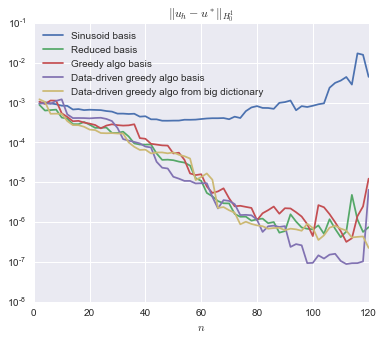

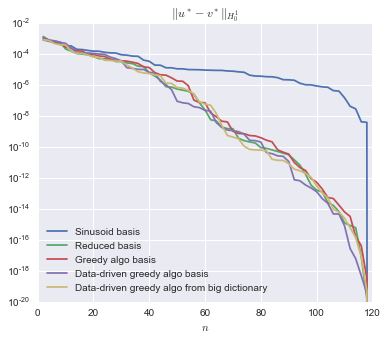

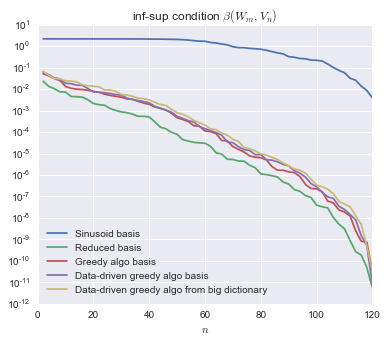

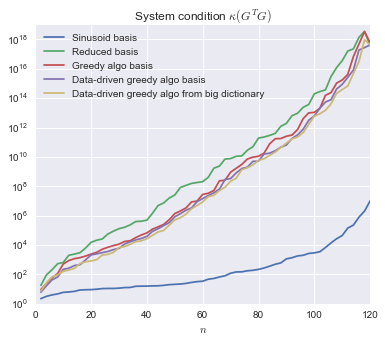

In [22]:

fig1, ax1 = plt.subplots(figsize=(6,5))
ax1.set(title='$\| u_h - u^* \|_{H_0^1}$')
ax1.set(yscale="log", xlabel='$n$')

fig2, ax2 = plt.subplots(figsize=(6,5))
ax2.set(title='$\| u^* - v^* \|_{H_0^1}$')
ax2.set(yscale="log", xlabel='$n$')

#fig3, ax3 = plt.subplots(figsize=(6,5), title='$\| u_h - P_{V_n} u_h \|_{H_0^1}$'))
#ax3.set(yscale="log", xlabel='$n$')

fig4, ax4 = plt.subplots(figsize=(6,5))
ax4.set(title=r'inf-sup condition $\beta(W_m, V_n)$')
ax4.set(yscale='log', xlabel='$n$')

fig5, ax5 = plt.subplots(figsize=(6,5))
ax5.set(title=r'System condition $\kappa(G^T G)$')
ax5.set(yscale="log", xlabel='$n$')

ns = range(2, m+1, 2)

for j, basis_label in enumerate(basis_labels):

    ax1.plot(ns, stats[0, j, :], label=basis_label)
    ax1.legend(loc=2)
    
    fig1.savefig('ddgrb_reconstruction_error.pdf')
    
    ax2.plot(ns, stats[1, j, :], label=basis_label)
    ax2.legend(loc=3)
    fig2.savefig('ddgrb_u_star_v_star_diff.pdf')

    ax4.plot(ns, stats[2, j, :], label=basis_label)
    ax4.legend(loc=3)
    fig4.savefig('ddgrb_inf_sup_cond.pdf')
    
    ax5.plot(ns, stats[3, j, :], label=basis_label)
    ax5.legend(loc=2)
    fig5.savefig('ddgrb_system_cond_number.pdf')